In [ ]:
# ! pip install chart_studio

In [ ]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
df = pd.read_csv('data/opportunities.csv',low_memory=False)

In [ ]:
df.loc[df['Opportunity_ID'] == 11112,['Opportunity_Name','Total_Amount','Total_Taxable_Amount','Stage']]

,Opportunity_Name,Total_Amount,Total_Taxable_Amount,Stage
16063,Opportunity_Name_5000,1.320000e+09,11867301.99,Proposal


In [ ]:
df.loc[df['Opportunity_Name'] == "Opportunity_Name_5000",['Opportunity_ID']]

,Opportunity_ID
16063,11112


In [ ]:
#funcion para calcular la conversion a dolar
def conversion(x):
    if (x["Total_Taxable_Amount_Currency"] == "USD"):
        return 1
    elif (x["Total_Taxable_Amount_Currency"] == x["ASP_Currency"] and float(x["ASP"]) != 0):  
        return x["ASP_(converted)"] / float(x["ASP"])
    else:
        return None

In [ ]:
#creo condicion donde para filtrar registros donde no tenga manera de convertir a moneda el total taxeable
condition = (df['Total_Taxable_Amount_Currency'] != df['Total_Amount_Currency'])\
& (df['Total_Taxable_Amount_Currency'] != df['ASP_Currency'])\
& (df['Total_Taxable_Amount_Currency'] != df['ASP_(converted)_Currency'])

## Top 10 de oportunidades exitosas ordenada por el monto total 

In [ ]:
#filtro por oportunidades exitosas
df_close_won = df.loc[df['Stage'] == 'Closed Won']
#quedan 5 registros afuera de los mas de 9000
df_close_won_filtered = df_close_won.loc[condition!= True,['Opportunity_Name','Opportunity_ID','Price','Currency','Total_Amount','Total_Amount_Currency','ASP','ASP_Currency','ASP_(converted)','ASP_(converted)_Currency','Total_Taxable_Amount','Total_Taxable_Amount_Currency','Planned_Delivery_Start_Date']]
df_close_won_filtered

,Opportunity_Name,Opportunity_ID,Price,Currency,Total_Amount,Total_Amount_Currency,ASP,ASP_Currency,ASP_(converted),ASP_(converted)_Currency,Total_Taxable_Amount,Total_Taxable_Amount_Currency,Planned_Delivery_Start_Date
1,Opportunity_Name_12600,1,None,None,48230.0,EUR,0.530,EUR,0.59948,USD,48230.00,EUR,1/18/2016
2,Opportunity_Name_469,2,None,None,83865.6,USD,0.480,USD,0.48000,USD,83865.60,USD,1/25/2016
7,Opportunity_Name_8227,7,None,None,50688.0,USD,0.480,USD,0.48000,USD,50688.00,USD,1/25/2016
23,Opportunity_Name_7036,11,None,None,1621851.0,USD,0.539,USD,0.53900,USD,1621851.00,USD,1/9/2016
63,Opportunity_Name_4062,20,None,None,103350.0,EUR,0.530,EUR,0.59948,USD,103350.00,EUR,1/18/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16937,Opportunity_Name_4060,12797,None,None,413400.0,EUR,0.530,EUR,0.59948,USD,528918.75,EUR,2/1/2016
16939,Opportunity_Name_7202,12799,None,None,401700.0,EUR,0.515,EUR,0.58251,USD,401700.00,EUR,4/1/2016
16942,Opportunity_Name_9245,12801,None,None,103350.0,EUR,0.520,EUR,0.58817,USD,299715.00,EUR,3/21/2016
16943,Opportunity_Name_9245,12801,None,None,93015.0,EUR,0.520,EUR,0.58817,USD,299715.00,EUR,4/4/2016


In [ ]:
#agrego el valor de conversion a moneda dolar
df_close_won_filtered["convertion"] = df_close_won_filtered.apply(conversion, axis=1)
df_close_won_filtered["convertion"].value_counts()

1.000000    3593
1.131095     169
0.008990     141
1.131091     139
0.008990     136
            ... 
1.131108       1
0.707623       1
0.707621       1
0.009049       1
0.008935       1
Name: convertion, Length: 186, dtype: int64

In [ ]:
#Convierto el total tax amount a moneda dolar para poder comparar
df_close_won_filtered["Total Taxable Amount (USD)"] = df_close_won_filtered["Total_Taxable_Amount"] * df_close_won_filtered["convertion"]

#agrupo por oportunidad
df_opportunity_Name = df_close_won_filtered.groupby(["Opportunity_Name","Opportunity_ID"]).agg({"Total Taxable Amount (USD)":"mean"})\
.reset_index().nlargest(10,"Total Taxable Amount (USD)")

#Preparo la tabla a mostrar
df_opportunity_table = df_opportunity_Name.loc[:,["Opportunity_Name","Total Taxable Amount (USD)"]]\
.rename(columns={"Opportunity_Name": "Opportunity"})

In [ ]:
# table = ff.create_table(df_opportunity_table)
# py.iplot(table)

In [ ]:
#agrupo por oportunidad y vendedor y me quedo con su estado
df_aux = df.loc[:,["Opportunity_Owner","Stage","Opportunity_Name"]].groupby(["Opportunity_Name","Opportunity_Owner"])\
.agg({'Stage':'last'}).reset_index()
#agrupo solo por vendedor y cuento la cantidad de apariciones de los estados para ese vendedor
df_owner = df_aux.groupby("Opportunity_Owner")["Stage"].value_counts().to_frame()
#si no tiene cierto estado para alguna oportunidad lleno con 0
df_owner2 = df_owner.unstack().fillna(0)
#renombro las columnas
df_owner2.columns = ["Closed Lost","Closed Won","Negotiation","Proposal","Qualification"]
#calculo el total de oportunidades para cada vendedor
df_owner2["Total Oportunities"] = df_owner2.agg('sum',axis="columns")
#calculo la relacion entre oportunidades exitosas y totales para cada vendedor
df_owner2["Win/Total"] = df_owner2["Closed Won"] / df_owner2["Total Oportunities"]
#calculo la relacion entre oportunidades perdidas y totales para cada vendedor
df_owner2["Lost/Total"] = df_owner2["Closed Lost"] / df_owner2["Total Oportunities"]
#calculo la relacion entre oportunidades exitosas y pedidas para cada vendedor
df_owner2["Win/Lost"] = df_owner2["Closed Won"] / df_owner2["Closed Lost"]
#ordeno por la relacion de exitosas sobre perdidas de manera descendente
df_owner2 = df_owner2.sort_values(by = "Win/Total",ascending = False).reset_index()
#filtro los vendedores que tengan menos oportunidades que el promedio de oportunidades
df_final_owner = df_owner2.loc[df_owner2["Total Oportunities"] >= df_owner2["Total Oportunities"].mean()]
df_final_owner

,Opportunity_Owner,Closed Lost,Closed Won,Negotiation,Proposal,Qualification,Total Oportunities,Win/Total,Lost/Total,Win/Lost
1,Person_Name_19,12.0,399.0,0.0,0.0,0.0,411.0,0.970803,0.029197,33.250000
4,Person_Name_32,141.0,469.0,0.0,0.0,1.0,611.0,0.767594,0.230769,3.326241
7,Person_Name_64,108.0,231.0,4.0,0.0,0.0,343.0,0.673469,0.314869,2.138889
8,Person_Name_66,63.0,124.0,0.0,4.0,0.0,191.0,0.649215,0.329843,1.968254
9,Person_Name_50,356.0,595.0,0.0,1.0,6.0,958.0,0.621086,0.371608,1.671348
13,Person_Name_13,322.0,434.0,1.0,0.0,0.0,757.0,0.573316,0.425363,1.347826
14,Person_Name_8,334.0,429.0,0.0,0.0,0.0,763.0,0.562254,0.437746,1.284431
15,Person_Name_23,117.0,149.0,0.0,0.0,0.0,266.0,0.560150,0.439850,1.273504
16,Person_Name_49,106.0,123.0,0.0,1.0,0.0,230.0,0.534783,0.460870,1.160377
20,Person_Name_18,353.0,329.0,0.0,0.0,0.0,682.0,0.482405,0.517595,0.932011


In [ ]:
data = df_owner.rename(columns={"Stage": "Count"}).reset_index()
data = data.loc[data["Stage"].isin(['Closed Won','Closed Lost']),:]
data["Total"] = pd.to_numeric(data.groupby("Opportunity_Owner").transform("sum")["Count"],downcast="float")
data["Win/Total"] = data["Count"] / data["Total"]
data = data.nlargest(20,"Total")
data

,Opportunity_Owner,Stage,Count,Total,Win/Total
79,Person_Name_50,Closed Won,595,951.0,0.625657
80,Person_Name_50,Closed Lost,356,951.0,0.374343
118,Person_Name_8,Closed Won,429,763.0,0.562254
119,Person_Name_8,Closed Lost,334,763.0,0.437746
6,Person_Name_13,Closed Won,434,756.0,0.574074
7,Person_Name_13,Closed Lost,322,756.0,0.425926
13,Person_Name_18,Closed Lost,353,682.0,0.517595
14,Person_Name_18,Closed Won,329,682.0,0.482405
34,Person_Name_32,Closed Won,469,610.0,0.768852
35,Person_Name_32,Closed Lost,141,610.0,0.231148


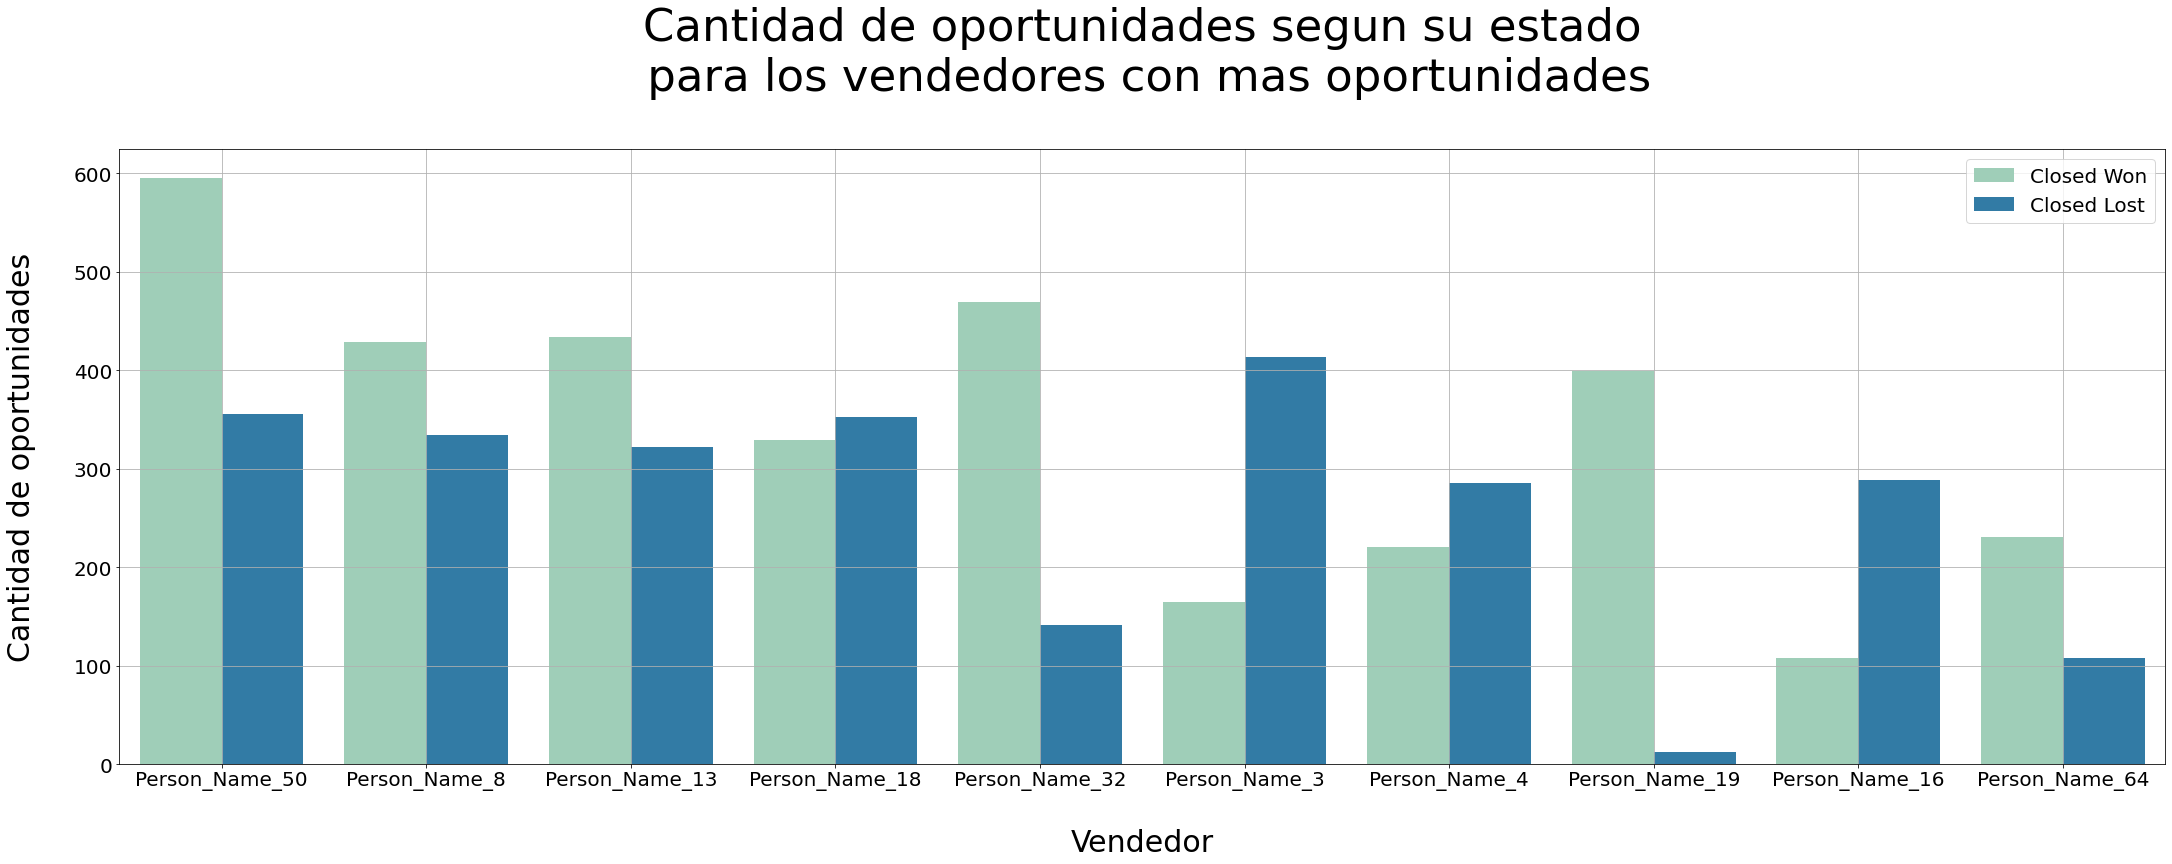

In [ ]:
fig,ax=plt.subplots(figsize=(30,12))

g = sns.barplot(ax=ax,data=data,x='Opportunity_Owner',y='Count',palette='YlGnBu',alpha=1,hue='Stage')
g.set_title('Cantidad de oportunidades segun su estado\n para los vendedores con mas oportunidades\n',size=45)
g.set_xlabel('\nVendedor',size=30)
g.set_ylabel('Cantidad de oportunidades\n',size=30)

plt.grid(True)
plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(ncol=1,fontsize=20)
#plt.savefig("pngs/vendedor-cantidad-op.png")
plt.show()


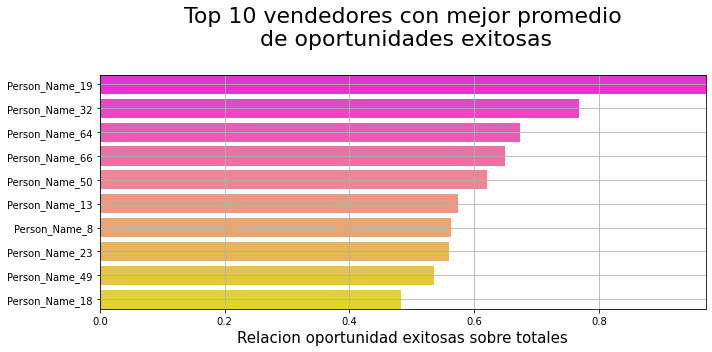

In [ ]:
show = df_final_owner.head(10)
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=show,x='Win/Total',y='Opportunity_Owner',palette="spring")

plt.grid(True)
plt.xlabel('Relacion oportunidad exitosas sobre totales',size=15)
plt.ylabel('')
plt.title('Top 10 vendedores con mejor promedio\n de oportunidades exitosas\n',size=22)
plt.margins(0,0)
plt.tight_layout()
#plt.savefig("pngs/vendedor-cantidad-op-exitosa.png")
plt.show()

In [ ]:
df_close_won_owner = df_close_won.loc[condition!= True,['Opportunity_Name','Opportunity_Owner','Total_Amount','Total_Amount_Currency','ASP','ASP_Currency','ASP_(converted)','ASP_(converted)_Currency','Total_Taxable_Amount','Total_Taxable_Amount_Currency']]
#agrego el valor de conversion a moneda dolar
df_close_won_owner["convertion"] = df_close_won_owner.apply(conversion, axis=1)
#Convierto el total tax amount a moneda dolar para poder comparar
df_close_won_owner["Total Taxable Amount (USD)"] = df_close_won_owner["Total_Taxable_Amount"] * df_close_won_owner["convertion"]
#agrupo por oportunidad y vendedor para obtener el promedio del monto total 
df_close_won_owner = df_close_won_owner.groupby(["Opportunity_Name","Opportunity_Owner"]).agg({"Total Taxable Amount (USD)":"mean"}).reset_index()
#agrupo por vendedor para obtener la suma de los promedios de los montos totales de sus oportunidades exitosas 
df_close_won_owner = df_close_won_owner.groupby(["Opportunity_Owner"]).agg({"Total Taxable Amount (USD)":"sum"}).reset_index()
#me quedo con los 10 vendedores con mayor dinero obtenido
df_close_won_owner = df_close_won_owner.nlargest(10,"Total Taxable Amount (USD)")
df_close_won_owner

,Opportunity_Owner,Total Taxable Amount (USD)
48,Person_Name_8,5.841786e+08
2,Person_Name_13,2.326947e+08
23,Person_Name_4,1.405619e+08
1,Person_Name_12,1.057469e+08
5,Person_Name_18,1.022239e+08
32,Person_Name_49,4.718963e+07
16,Person_Name_32,4.385771e+07
30,Person_Name_46,4.261223e+07
6,Person_Name_19,4.025880e+07
47,Person_Name_66,3.326011e+07


Text(0.5, 1.0, 'Vendedores con mayor dinero generado con oportunidades exitosas\n')

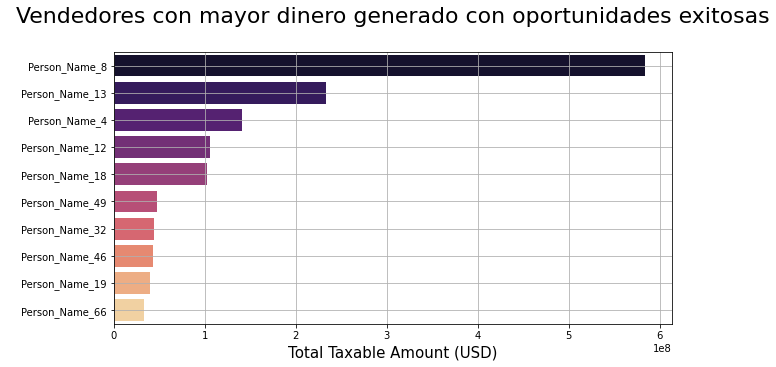

In [ ]:
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=df_close_won_owner,x='Total Taxable Amount (USD)',y='Opportunity_Owner',palette="magma")
plt.grid(True)
plt.xlabel('Total Taxable Amount (USD)',size=15)
plt.ylabel(' ')
plt.title('Vendedores con mayor dinero generado con oportunidades exitosas\n',size=22)

In [ ]:
df_acc_opp = df.loc[:,["Opportunity_Name","Stage","Opportunity_Owner","Account_Owner"]]
df_acc_opp["Opportunity_Owner is Account_Owner"] = df_acc_opp["Opportunity_Owner"] == df_acc_opp["Account_Owner"]
df_acc_opp = df_acc_opp.groupby(["Opportunity_Name","Stage"]).agg({"Opportunity_Owner is Account_Owner":"first"}).reset_index()
df_acc_opp = df_acc_opp.groupby(["Stage","Opportunity_Owner is Account_Owner"]).count().reset_index()
df_acc_opp.columns = ["Stage","Opportunity_Owner equals Account_Owner","Count"]
df_acc_opp

,Stage,Opportunity_Owner equals Account_Owner,Count
0,Closed Lost,False,893
1,Closed Lost,True,3826
2,Closed Won,False,1459
3,Closed Won,True,3613
4,Negotiation,True,11
5,Proposal,False,1
6,Proposal,True,29
7,Qualification,True,9


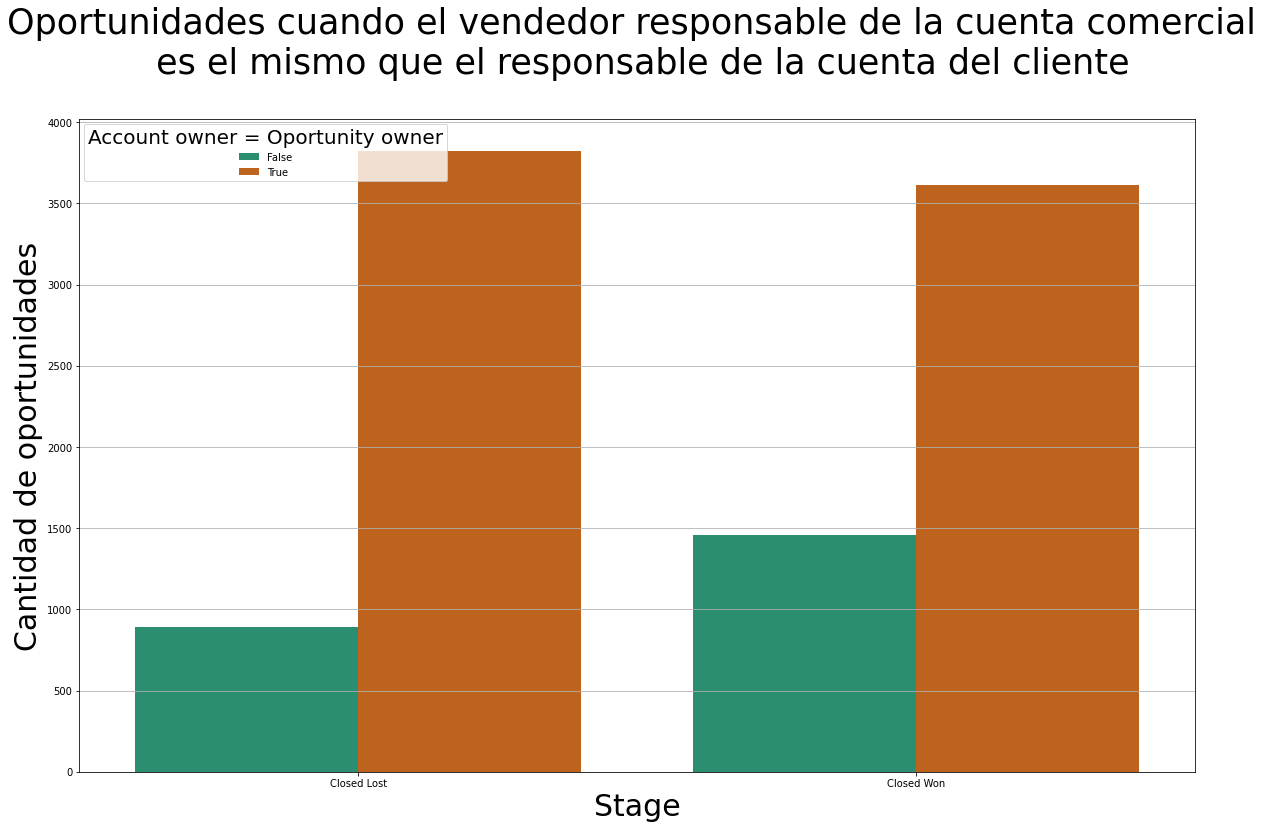

In [ ]:
df_acc_opp_data = df_acc_opp.loc[df_acc_opp["Stage"].isin(['Closed Won','Closed Lost']),:]

fig,ax=plt.subplots(figsize=(20,12))
plt.grid(True)
g = sns.barplot(ax=ax,data=df_acc_opp_data,x='Stage',y='Count',palette='Dark2',hue='Opportunity_Owner equals Account_Owner')
g.set_title('Oportunidades cuando el vendedor responsable de la cuenta comercial \n es el mismo que el responsable de la cuenta del cliente\n',size=35)
g.set_xlabel('Stage',size=30)
g.set_ylabel('Cantidad de oportunidades',size=30)
g.legend(title='Account owner = Oportunity owner',fontsize = '10',title_fontsize='20',loc='upper left')

In [ ]:
df.loc[df["Opportunity_Name"] == "Opportunity_Name_9990",["Opportunity_Type"]]
df_opp_type = df.loc[:,["Opportunity_Name","Opportunity_Type","Stage"]].groupby(["Opportunity_Name","Opportunity_Type"])["Stage"].value_counts().to_frame()
df_opp_type["Stage"] = 1
df_opp_type["total"] = df_opp_type["Stage"].sum()
df_opp_type = df_opp_type.rename(columns={"Stage": "Count"}).reset_index()

df_opp_type_show = df_opp_type.groupby("Opportunity_Type").agg({"Count":"sum","total":"mean"}).reset_index()
df_opp_type_show.columns = ["Opportunity_Type","Count","Total opportunities"]
df_opp_type_show["Count/Total"] = df_opp_type_show["Count"] / df_opp_type_show["Total opportunities"]
df_opp_type_show["Percentage"] = df_opp_type_show["Count/Total"] * 100
df_opp_type_show

,Opportunity_Type,Count,Total opportunities,Count/Total,Percentage
0,Opportunity_Type_0,7,9841,0.000711,0.071131
1,Opportunity_Type_1,5160,9841,0.524337,52.433696
2,Opportunity_Type_10,15,9841,0.001524,0.152424
3,Opportunity_Type_11,2,9841,0.000203,0.020323
4,Opportunity_Type_12,138,9841,0.014023,1.402297
5,Opportunity_Type_13,4,9841,0.000406,0.040646
6,Opportunity_Type_14,10,9841,0.001016,0.101616
7,Opportunity_Type_15,9,9841,0.000915,0.091454
8,Opportunity_Type_16,1,9841,0.000102,0.010162
9,Opportunity_Type_17,3,9841,0.000305,0.030485


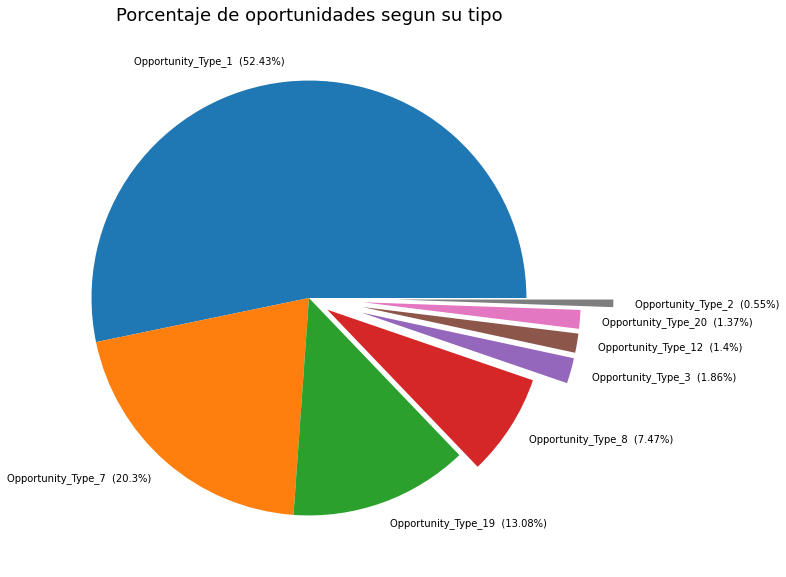

In [ ]:
data_show_pie = df_opp_type_show.round(2).nlargest(8,"Percentage")
fig1,ax1 = plt.subplots(figsize=(10,10))

labels=data_show_pie['Opportunity_Type']+"  (" + (data_show_pie['Percentage']).astype(str) + "%)"
explode = (0,0,0,0.1,0.25,0.25,0.25,0.4)
colors = [] #podemos cambiar los colores

ax1.axis('equal')
ax1.pie(data_show_pie['Percentage'],labels=labels,explode=explode)
plt.title('Porcentaje de oportunidades segun su tipo',size=18)
plt.show()

(array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 <a list of 6 Text major ticklabel objects>)

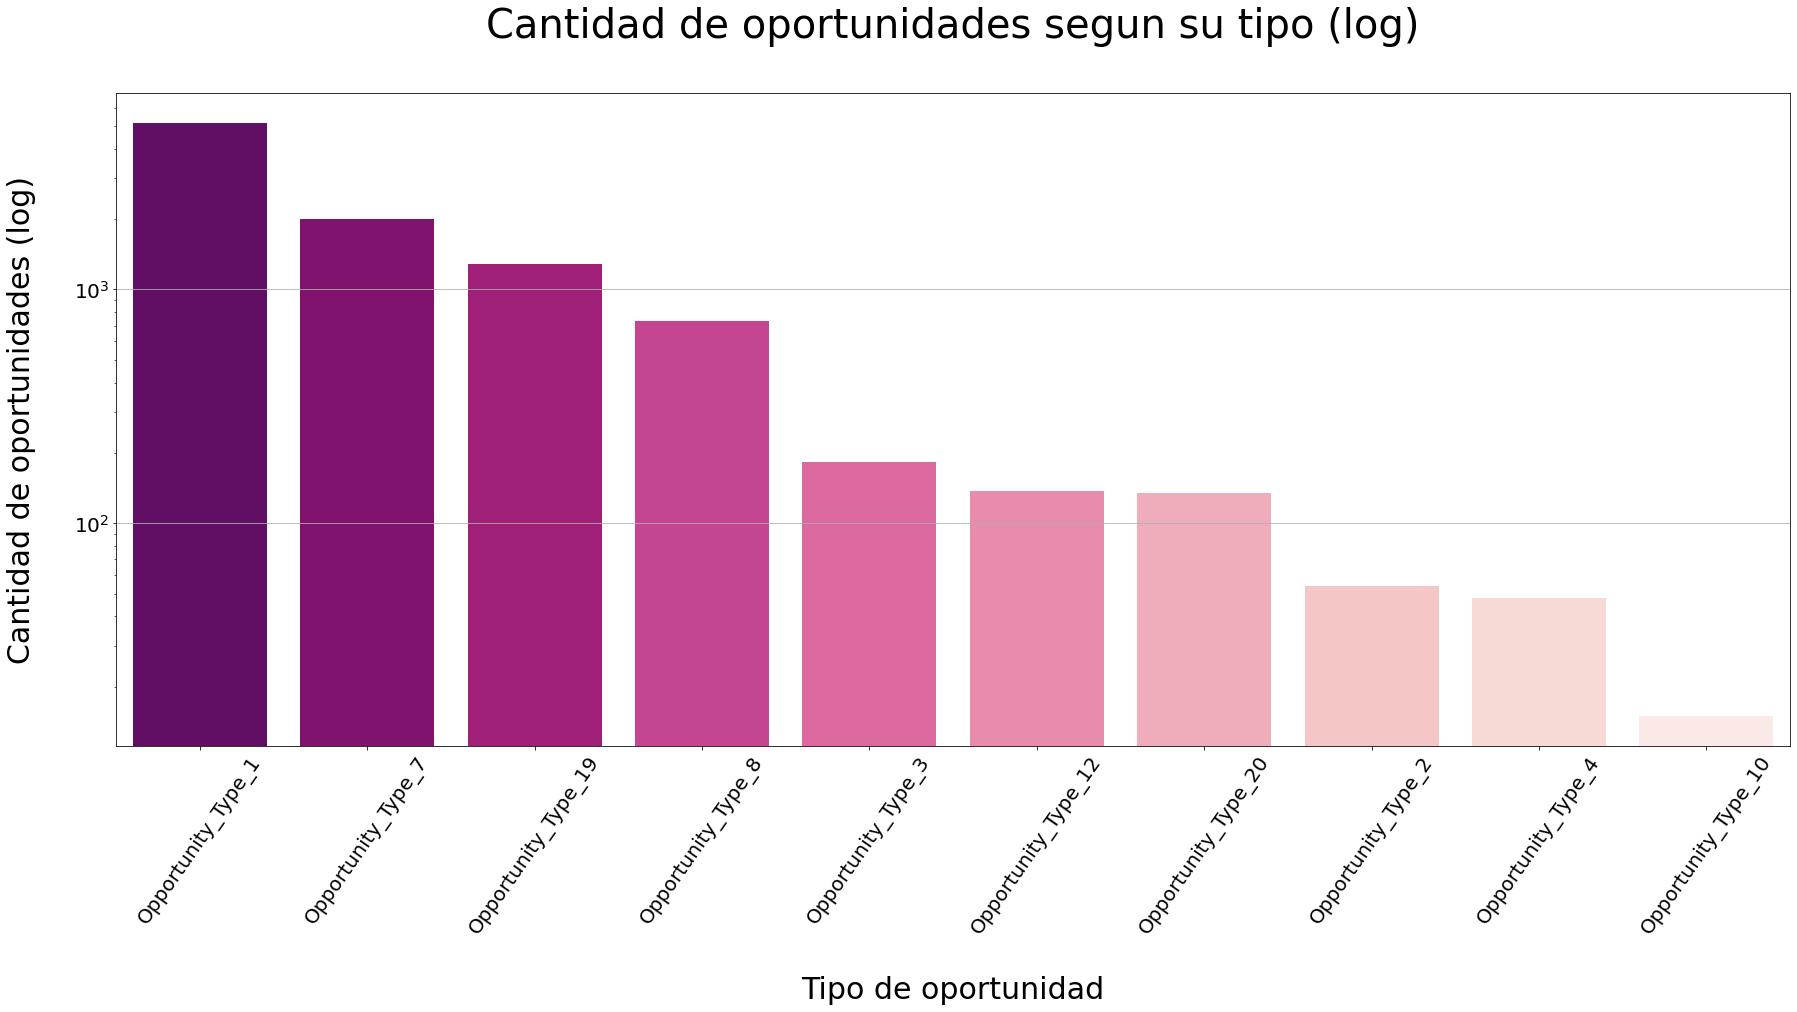

In [ ]:
data_opp_type_show_bar = df_opp_type_show.round(2).nlargest(10,"Percentage")

fig,ax=plt.subplots(figsize=(30,12))
plt.yscale('log')
plt.grid(True)
g = sns.barplot(ax=ax,data=data_opp_type_show_bar,x='Opportunity_Type',y='Count',palette='RdPu_r',alpha=1)
g.set_title('Cantidad de oportunidades segun su tipo (log)\n',size=40)
g.set_xlabel('\nTipo de oportunidad',size=30)
g.set_ylabel('Cantidad de oportunidades (log)\n',size=30)

plt.xticks(fontsize=20,rotation=55)
plt.yticks(fontsize=20)
#plt.savefig("pngs/canti-op-tipo-log.png")


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 <a list of 7 Text major ticklabel objects>)

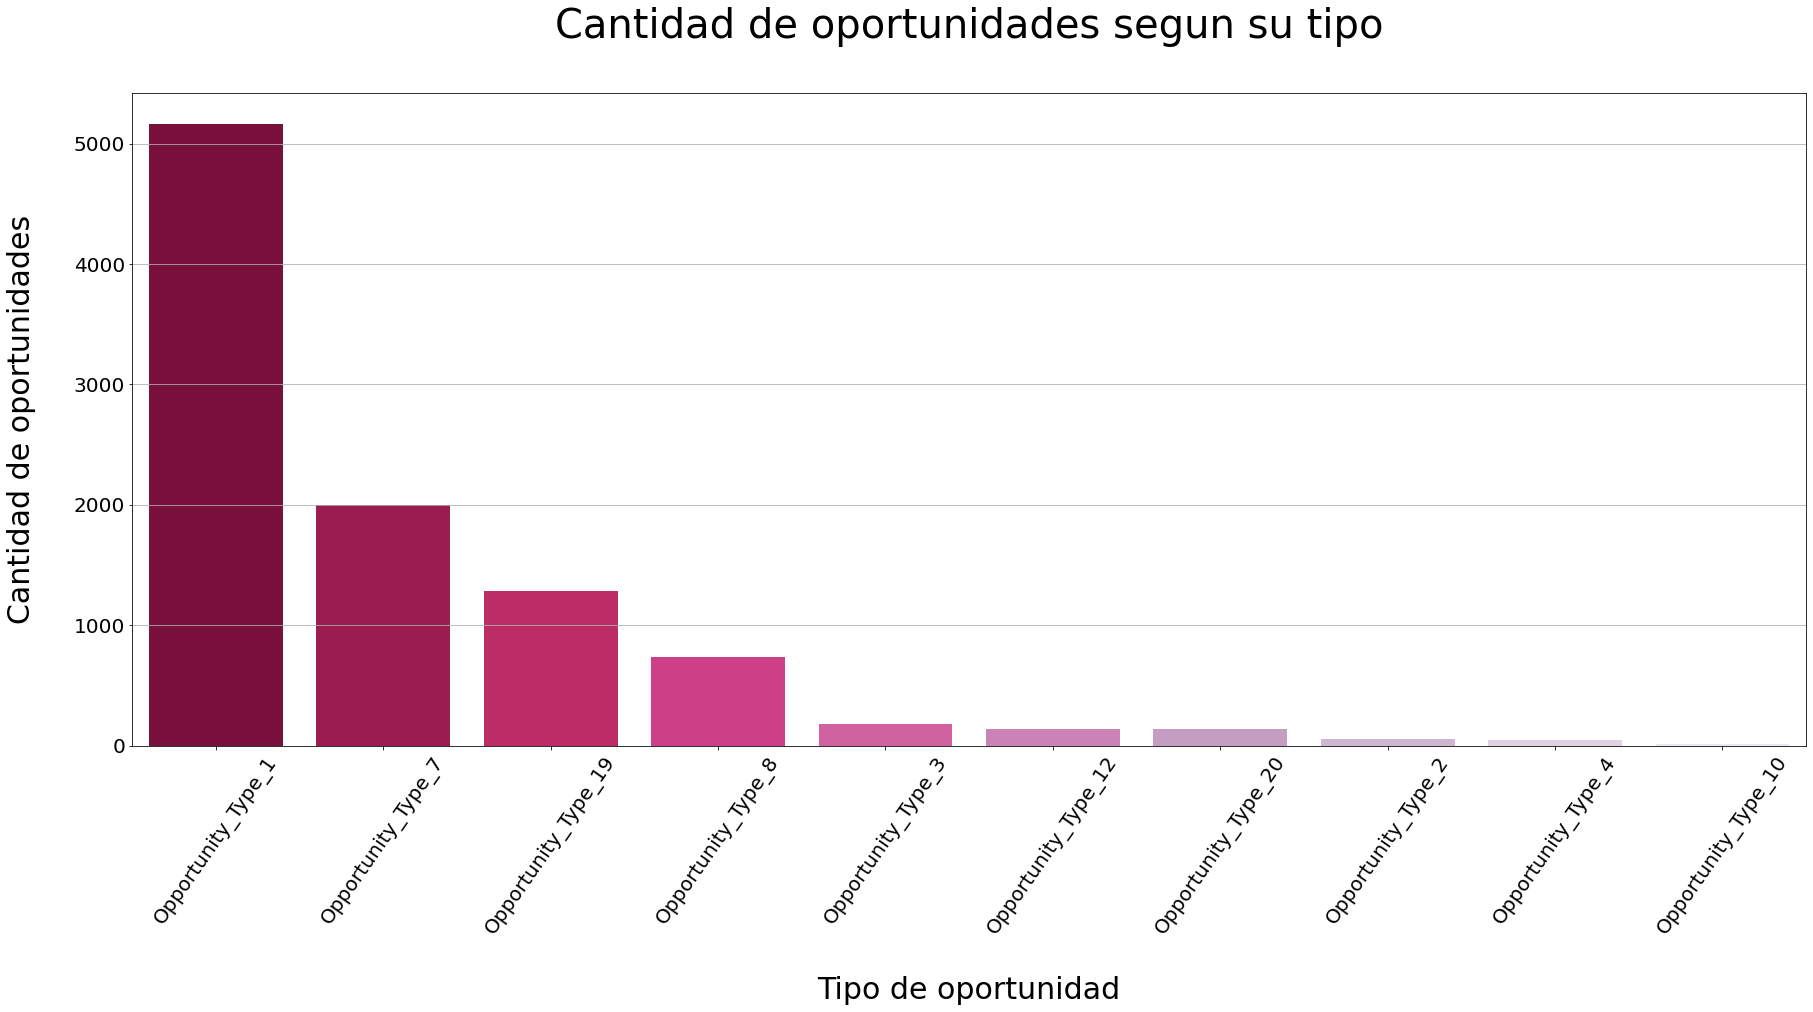

In [ ]:
data_opp_type_show_bar = df_opp_type_show.round(2).nlargest(10,"Percentage")

fig,ax=plt.subplots(figsize=(30,12))
plt.grid(True)
g = sns.barplot(ax=ax,data=data_opp_type_show_bar,x='Opportunity_Type',y='Count',palette='PuRd_r',alpha=1)
g.set_title('Cantidad de oportunidades segun su tipo\n',size=40)
g.set_xlabel('\nTipo de oportunidad',size=30)
g.set_ylabel('Cantidad de oportunidades\n',size=30)

plt.xticks(fontsize=20,rotation=55)
plt.yticks(fontsize=20)
#plt.savefig("pngs/canti-op-tipo.png")


In [ ]:
df_opportunity_table.head()

,Opportunity,Total Taxable Amount (USD)
4325,Opportunity_Name_844,1.776277e+08
3284,Opportunity_Name_6470,4.183522e+07
2665,Opportunity_Name_4713,3.163769e+07
2719,Opportunity_Name_4854,3.141078e+07
2782,Opportunity_Name_5036,3.105361e+07


## top paises con mas cantidad de facturas emitidas

In [ ]:
df = pd.read_csv('data/opportunities.csv',low_memory=False)
df_bp = df.copy()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None


In [ ]:
df_bp = df_bp.groupby("Opportunity_ID").agg({'Billing_Country': 'first', 'Stage': 'first', 'ID': 'count'}).reset_index()
top_10 = df_bp.groupby("Billing_Country").agg({'ID': 'count'}).reset_index().nlargest(10, "ID")['Billing_Country']

In [ ]:
df_bp = df_bp[df_bp["Stage"].str.contains("Closed")]
df_bp = df_bp.groupby(["Billing_Country", "Stage"]).agg({'ID': 'count'}).reset_index()
df_bp_top = df_bp[df_bp['Billing_Country'].isin(top_10).to_list()]

,Billing_Country,Stage,ID
3,Australia,Closed Lost,176
4,Australia,Closed Won,382
35,France,Closed Lost,254
36,France,Closed Won,90
38,Germany,Closed Lost,636
39,Germany,Closed Won,670
44,India,Closed Lost,323
45,India,Closed Won,236
49,Italy,Closed Lost,121
50,Italy,Closed Won,93


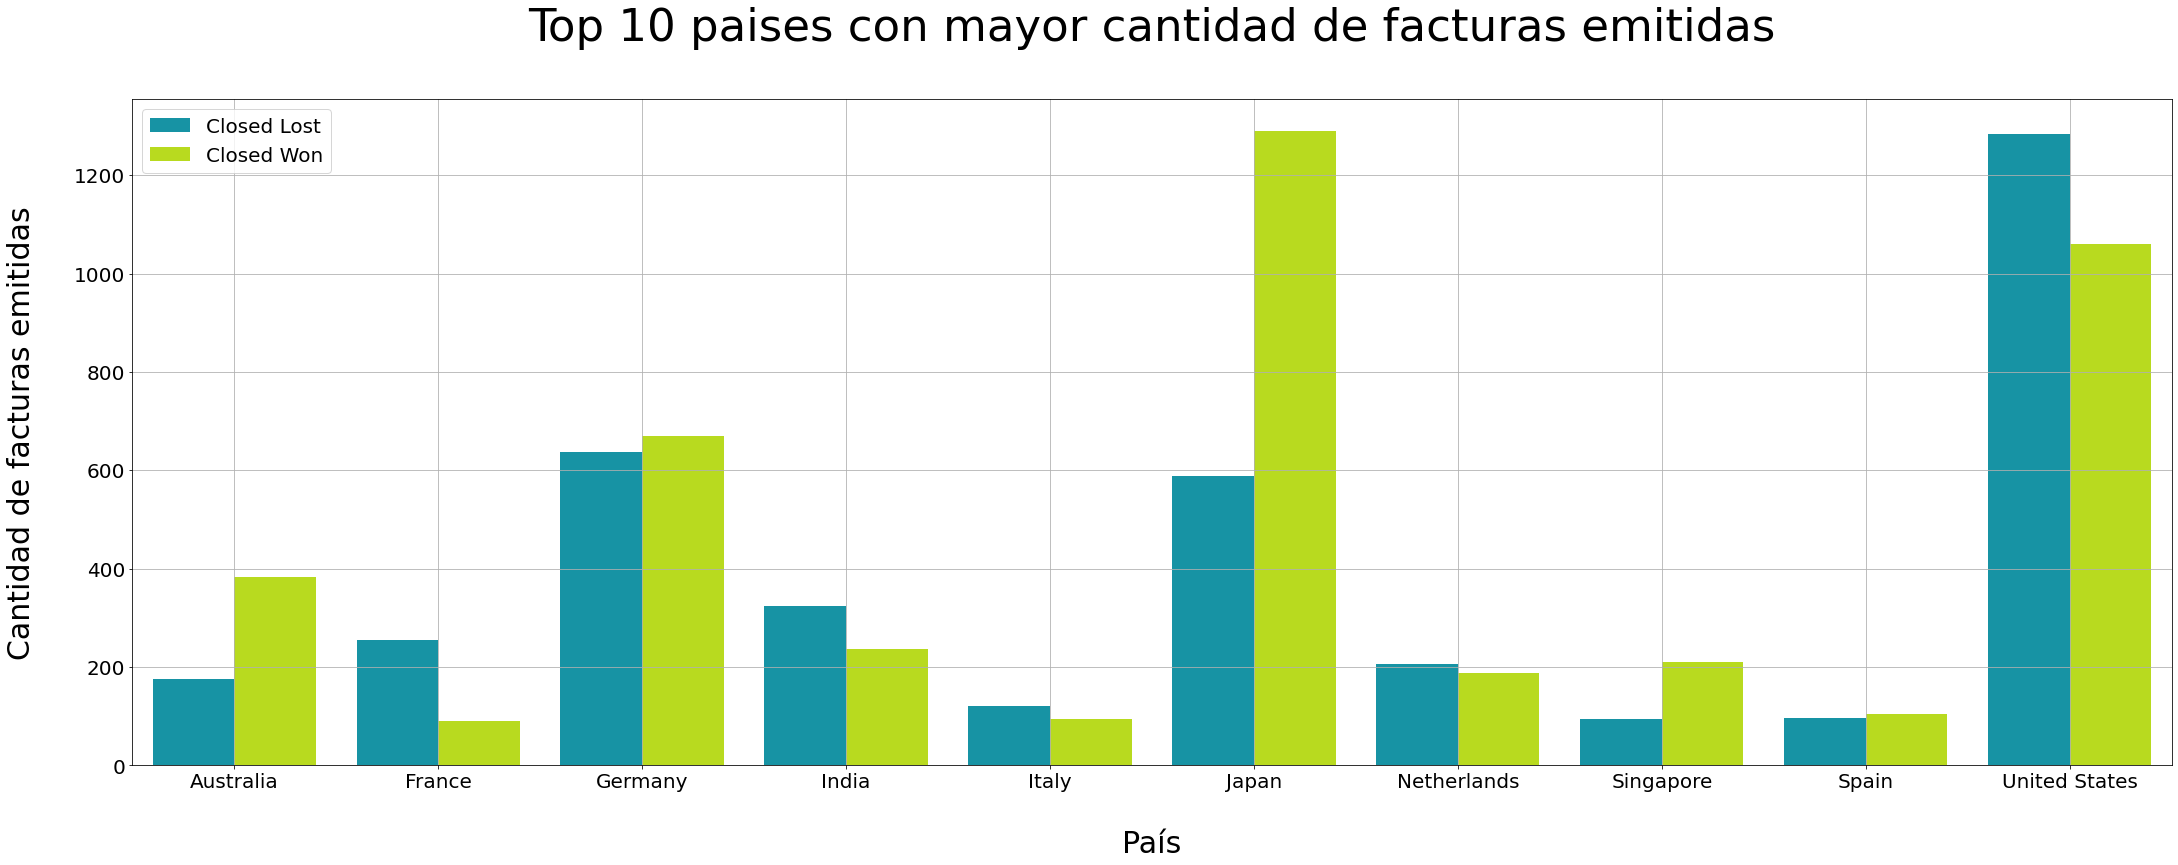

In [ ]:
fig,ax=plt.subplots(figsize=(30,12))

g = sns.barplot(ax=ax, \
                data=df_bp_top, \
                x='Billing_Country', \
                y='ID', \
                palette='nipy_spectral', \
                alpha=1, \
                hue='Stage')
g.set_title('Top 10 paises con mayor cantidad de facturas emitidas\n',size=45)
g.set_xlabel('\nPaís',size=30)
g.set_ylabel('Cantidad de facturas emitidas\n',size=30)

plt.grid(True)
plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(ncol=1,fontsize=20)
#plt.savefig("pngs/vendedor-cantidad-op.png")
plt.show()